In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load dataset
df = pd.read_csv('online_retail.csv', encoding='ISO-8859-1')  # or UTF-8 if that works


In [3]:
# Show first 5 rows
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2022-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2022-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [4]:
# Dataset shape (rows, columns)
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns")

Dataset contains 541909 rows and 8 columns


In [5]:
# View data types and null counts
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


In [6]:
# Summary statistics
print(df.describe(include='all'))


       InvoiceNo StockCode                         Description       Quantity  \
count     541909    541909                              540455  541909.000000   
unique     25900      4070                                4223            NaN   
top       573585    85123A  WHITE HANGING HEART T-LIGHT HOLDER            NaN   
freq        1114      2313                                2369            NaN   
mean         NaN       NaN                                 NaN       9.552250   
std          NaN       NaN                                 NaN     218.081158   
min          NaN       NaN                                 NaN  -80995.000000   
25%          NaN       NaN                                 NaN       1.000000   
50%          NaN       NaN                                 NaN       3.000000   
75%          NaN       NaN                                 NaN      10.000000   
max          NaN       NaN                                 NaN   80995.000000   

                InvoiceDate

In [7]:
# Check missing values per column
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])


Missing values:
 Description      1454
CustomerID     135080
dtype: int64


In [8]:
# Count and show duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


Number of duplicate rows: 5268


In [9]:
# Remove duplicates (optional here, or in preprocessing)
df = df.drop_duplicates()

In [10]:
cancelled = df[df['InvoiceNo'].astype(str).str.startswith('C')]
print(f"Number of cancelled invoices: {cancelled.shape[0]}")

Number of cancelled invoices: 9251


In [11]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]


In [12]:
# Quantity and UnitPrice issues
print(df[(df['Quantity'] <= 0) | (df['UnitPrice'] <= 0)].shape[0], "rows with invalid Quantity or Price")


2512 rows with invalid Quantity or Price


In [13]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]


In [14]:
print("Remaining invalid Quantity or Price rows:",
      df[(df['Quantity'] <= 0) | (df['UnitPrice'] <= 0)].shape[0])


Remaining invalid Quantity or Price rows: 0


In [15]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print("Date range:", df['InvoiceDate'].min(), "to", df['InvoiceDate'].max())

Date range: 2022-12-01 08:26:00 to 2023-12-09 12:50:00


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")


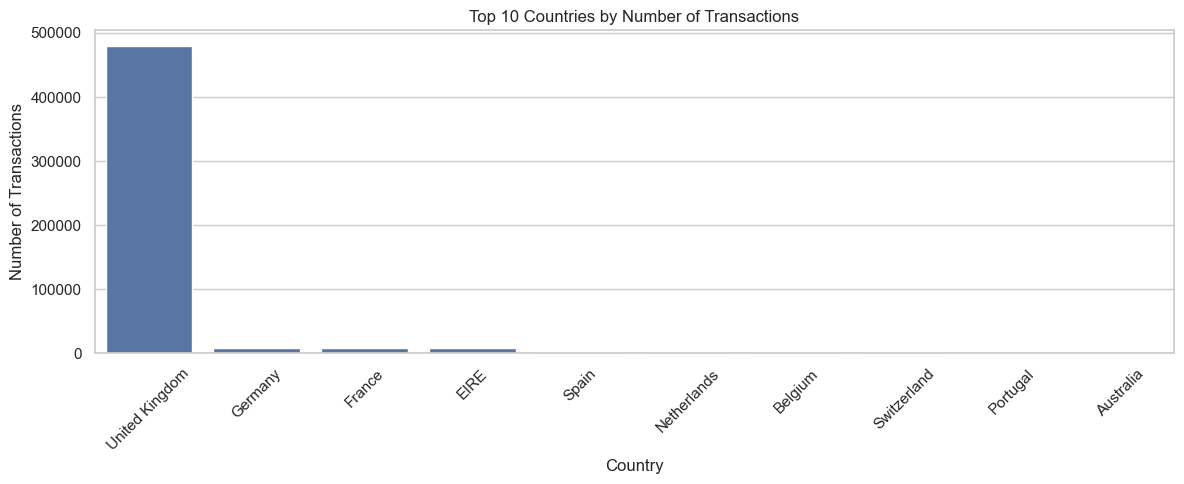

In [17]:
country_counts = df['Country'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x=country_counts.index[:10], y=country_counts.values[:10])
plt.title('Top 10 Countries by Number of Transactions')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

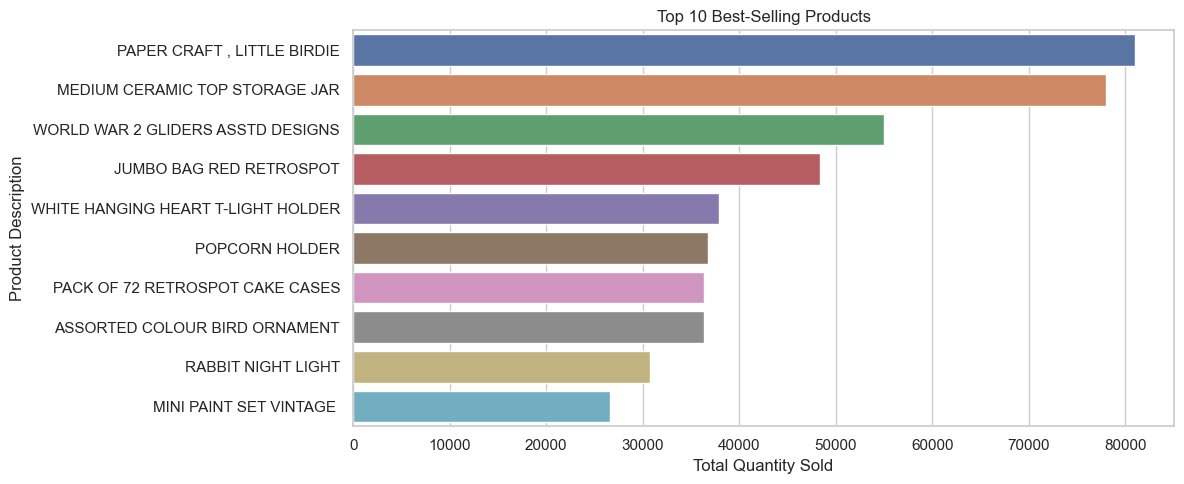

In [18]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 5))
sns.barplot(x=top_products.values, y=top_products.index, hue=top_products.index, dodge=False, legend=False)
plt.title('Top 10 Best-Selling Products')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()


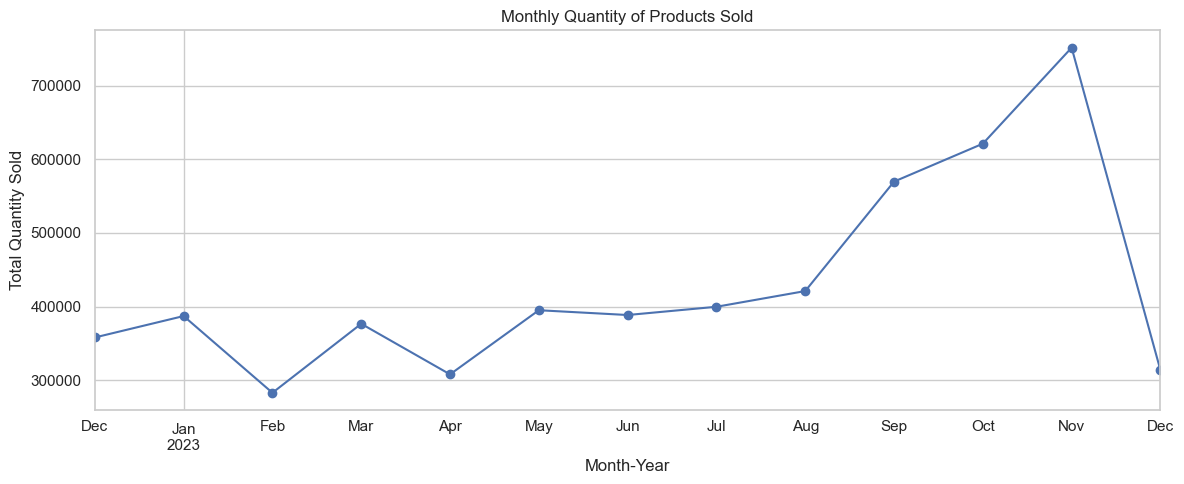

In [19]:
df['MonthYear'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('MonthYear')['Quantity'].sum()

monthly_sales.plot(kind='line', figsize=(12, 5), marker='o')
plt.title('Monthly Quantity of Products Sold')
plt.xlabel('Month-Year')
plt.ylabel('Total Quantity Sold')
plt.grid(True)
plt.tight_layout()
plt.show()


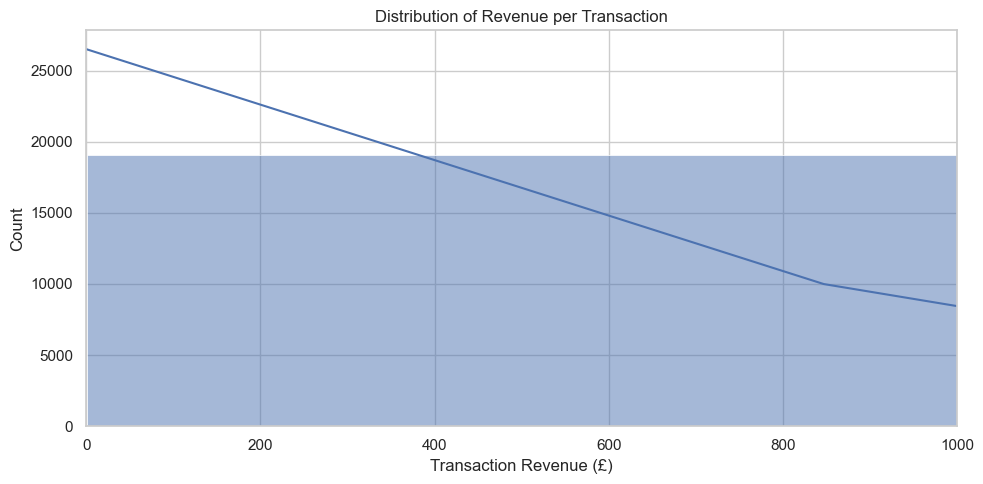

In [20]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

transaction_total = df.groupby('InvoiceNo')['TotalPrice'].sum()

plt.figure(figsize=(10, 5))
sns.histplot(transaction_total, bins=100, kde=True)
plt.title('Distribution of Revenue per Transaction')
plt.xlabel('Transaction Revenue (£)')
plt.xlim(0, 1000)  # Optional: Focus on typical range
plt.tight_layout()
plt.show()


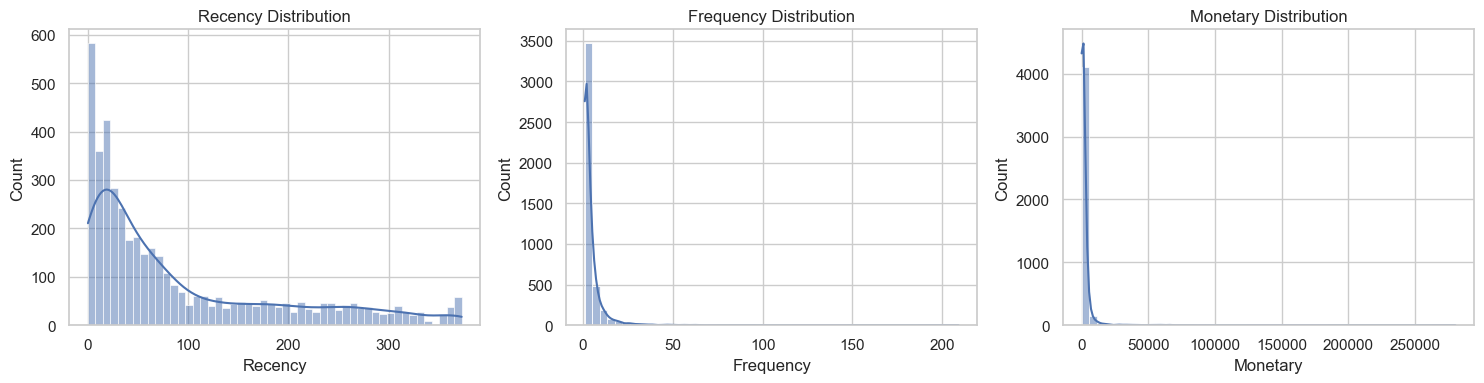

In [21]:
snapshot_date = df['InvoiceDate'].max()
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Histograms
plt.figure(figsize=(15, 4))
for i, col in enumerate(rfm.columns):
    plt.subplot(1, 3, i + 1)
    sns.histplot(rfm[col], bins=50, kde=True)
    plt.title(f'{col} Distribution')
    plt.tight_layout()
plt.show()


In [22]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [23]:
snapshot_date = df['InvoiceDate'].max()

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Preview
print(rfm.head())


   CustomerID  Recency  Frequency  Monetary
0     12346.0      325          1  77183.60
1     12347.0        1          7   4310.00
2     12348.0       74          4   1797.24
3     12349.0       18          1   1757.55
4     12350.0      309          1    334.40


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


In [27]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# RFM Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Elbow method
sse = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


AttributeError: 'NoneType' object has no attribute 'split'

Note: you may need to restart the kernel to use updated packages.
